# Clustering

Setup environment <br>
Import relevant libraries

In [ ]:
# %pip install scikit-learn
# %pip install matplotlib
# %pip install seaborn
# %pip install pandas

from bigdata_a3_utils import *
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os, pickle, gc

Define bath path

In [49]:
# base_path = Path('D:\COMP3610A3\dataframes')

## Load Categories

Define a function to combine the dataframes into one for analysis

In [50]:
# def get_dataset(base_path, category):
#     combined_df = pd.DataFrame()
    
#     for category in VALID_CATEGORIES:
#         try:
#             pickle_path = os.path.join(base_path, f'cleaned_data_{category}.pkl')
#             category_df = pd.read_pickle(pickle_path)
#         except Exception as e:
#             print(f"Error processing category {category}: {e}")
#             continue
        
#         print(f"Processing category: {category}")
#         category_df = category_df[['parent_asin', 'rating', 'brand', 'main_category']]
#         combined_df = pd.concat([combined_df, category_df], ignore_index=True)
        
#         del category_df
#         gc.collect()
    
#     if combined_df.empty:
#         print("No data available after processing all categories...")
#         return None
    
#     return combined_df
        

Now get the dataframe for the k-means clustering algorithm

In [51]:
# df = get_dataset(base_path, VALID_CATEGORIES)
# df.head()

In [52]:
def get_needed_cols(base_path, category):
    #columns we want
    needed= ['parent_asin', 'rating', 'brand', 'main_category']
    #read in pickle file
    print(f"Reading in {category} data")
    df= pd.read_pickle(base_path / f"cleaned_data_{category}.pkl")
    print(f"Finished reading in {category} data")
    
    columns_to_drop = df.columns.difference(needed)
    df.drop(columns=columns_to_drop, inplace=True)
    print("Dropped unneeded columns")
    gc.collect()
    return df

In [53]:
base_path= Path(f"D:\COMP3610A3\dataframes")

dfs = []

#test run. Please run this to ensure you are getting the categories in the list below
#Once working, comment test code and uncomment real code and then Run All
categories= ['All_Beauty', 'Amazon_Fashion', 'Appliances']
for category in categories:
    x = get_needed_cols(base_path, category)
    dfs.append(x)
    gc.collect()

df = pd.concat(dfs, ignore_index=True)

Reading in All_Beauty data
Finished reading in All_Beauty data
Dropped unneeded columns
Reading in Amazon_Fashion data
Finished reading in Amazon_Fashion data
Dropped unneeded columns
Reading in Appliances data
Finished reading in Appliances data
Dropped unneeded columns


## Features

Category id map

In [54]:
category_map = {
    'all beauty': 0,
    'amazon fashion': 1,
    'appliances': 2,
    'arts, crafts and sewing': 3,
    'automotive': 4,
    'baby products': 5,
    'beauty and personal care': 6,
    'books': 7,
    'cds and vinyl': 8,
    'cell phones and accessories': 9,
    'clothing shoes and jewelry': 10,
    'digital music': 11,
    'electronics': 12,
    'gift cards': 13,
    'grocery and gourmet food': 14,
    'handmade products': 15,
    'health and household': 16,
    'health and personal care': 17,
    'home and kitchen': 18,
    'industrial and scientific': 19,
    'kindle store': 20,
    'magazine subscriptions': 21,
    'movies and tv': 22,
    'musical instruments': 23,
    'office products': 24,
    'patio lawn and garden': 25,
    'pet supplies': 26,
    'software': 27,
    'sports and outdoors': 28,
    'subscription boxes': 29,
    'tools and home improvement': 30,
    'toys and games': 31,
    'video games': 32,
    'unknown': 33
}

Feature engineering

In [55]:
# Compute mean rating and total reviews for products
product_df = df.groupby('parent_asin').agg(
    mean_rating=('rating', 'mean'),
    total_reviews=('rating', 'count'),
    brand=('brand', lambda x: x.iloc[0]),
    main_category=('main_category', lambda x: x.iloc[0]),
).reset_index()

# Delete df to free up memory
del df
gc.collect()

# Encode categorical features, brand and main_category
print(f"Encoding categorical features...")
product_df['brand'] = product_df['brand'].fillna('Unknown')
product_df['main_category'] = product_df['main_category'].fillna('Unknown')

# Map category IDs
product_df['main_category'] = product_df['main_category'].str.replace('&', 'and').str.lower()
product_df['category_id'] = product_df['main_category'].map(category_map).fillna(33).astype(int)

# Apply label encoding 
encoder_brand = LabelEncoder()
product_df['brand'] = product_df['brand'].str.lower()
product_df['brand_id'] = encoder_brand.fit_transform(product_df['brand'])

# Prepare matrix
product_df = product_df[['parent_asin', 'mean_rating', 'total_reviews', 'brand_id', 'category_id']]
features = product_df[['mean_rating', 'total_reviews', 'brand_id', 'category_id']]

product_df.head()


Encoding categorical features...


,parent_asin,mean_rating,total_reviews,brand_id,category_id
0,0000099813,5.000000,3,70713,1
1,0005946468,5.000000,1,81872,0
2,0123034892,5.000000,1,108685,0
3,0124784577,4.333333,3,115451,0
4,0310807115,5.000000,1,108685,1


## k-means

In [56]:
# Apply KMeans clustering
print(f"Applying KMeans clustering...")
kmeans = KMeans(n_clusters=5, random_state=42)
product_df['cluster'] = kmeans.fit_predict(features)

product_df.head()

Applying KMeans clustering...


,parent_asin,mean_rating,total_reviews,brand_id,category_id,cluster
0,0000099813,5.000000,3,70713,1,3
1,0005946468,5.000000,1,81872,0,4
2,0123034892,5.000000,1,108685,0,0
3,0124784577,4.333333,3,115451,0,0
4,0310807115,5.000000,1,108685,1,0


## Cluster Analysis

In [57]:
# Analyse clusters
cluster_analysis = product_df.groupby('cluster').agg(
    cluster_size=('parent_asin', 'count'),
    avg_rating=('mean_rating', 'mean'),
    avg_total_reviews=('total_reviews', 'mean'),
    avg_brand_id=('brand_id', 'mean'),
    avg_category_id=('category_id', 'mean')
).reset_index()

for idx, row in cluster_analysis.iterrows():
    print(f"Cluster {int(row['cluster'])}:")
    print(f" - Size: {int(row['cluster_size'])}")
    print(f" - Avg Rating: {row['avg_rating']}")
    print(f" - Avg Total Reviews: {row['avg_total_reviews']}")
    print(f" - Avg Brand ID: {row['avg_brand_id']}")
    print(f" - Avg Category ID: {row['avg_category_id']}")


Cluster 0:
 - Size: 233409
 - Avg Rating: 3.8616473725361766
 - Avg Total Reviews: 4.734384706673693
 - Avg Brand ID: 110156.68571905968
 - Avg Category ID: 3.3930653916515645
Cluster 1:
 - Size: 219914
 - Avg Rating: 3.8809664229351077
 - Avg Total Reviews: 5.478077794046763
 - Avg Brand ID: 37680.935383831864
 - Avg Category ID: 3.432200769391671
Cluster 2:
 - Size: 198698
 - Avg Rating: 3.9045616713939166
 - Avg Total Reviews: 5.216177314316198
 - Avg Brand ID: 12806.438791532879
 - Avg Category ID: 2.490321996195231
Cluster 3:
 - Size: 189530
 - Avg Rating: 3.8661407747862198
 - Avg Total Reviews: 4.947844668390228
 - Avg Brand ID: 62915.95247190419
 - Avg Category ID: 2.193267556587348
Cluster 4:
 - Size: 190587
 - Avg Rating: 3.8994952780614565
 - Avg Total Reviews: 5.1777455964992365
 - Avg Brand ID: 86707.17415668436
 - Avg Category ID: 2.443650406376091


## Interpretation

Remap brand and category names

In [66]:
brand_mapping = dict(zip(encoder_brand.transform(encoder_brand.classes_), encoder_brand.classes_))
category_mapping = {v: k for k, v in category_map.items()}

# Add the original brand and category names to the dataframe
product_df['brand_name'] = product_df['brand_id'].map(brand_mapping)
product_df['category_name'] = product_df['category_id'].map(category_mapping)


Brand and category distribution within each cluster

In [60]:
product_df.head()

# Brand distribution within each cluster
brand_distribution = pd.DataFrame()
for cluster_id in range(5):
    # Get top 10 brands in this cluster
    cluster_brands = product_df[product_df['cluster'] == cluster_id]['brand_name'].value_counts().nlargest(10)
    brand_distribution[f'Cluster {cluster_id}'] = cluster_brands

# Category distribution within each cluster
category_distribution = pd.DataFrame()
for cluster_id in range(5):
    # Get category distribution in this cluster
    cluster_categories = product_df[product_df['cluster'] == cluster_id]['category_name'].value_counts()
    category_distribution[f'Cluster {cluster_id}'] = cluster_categories

# Calculate the percentage of each category within clusters
category_percentages = pd.DataFrame()
for cluster_id in range(5):
    cluster_df = product_df[product_df['cluster'] == cluster_id]
    category_counts = cluster_df['category_name'].value_counts()
    total_in_cluster = len(cluster_df)
    percentages = (category_counts / total_in_cluster * 100).round(2)
    category_percentages[f'Cluster {cluster_id}'] = percentages



Rating distribution within each cluster

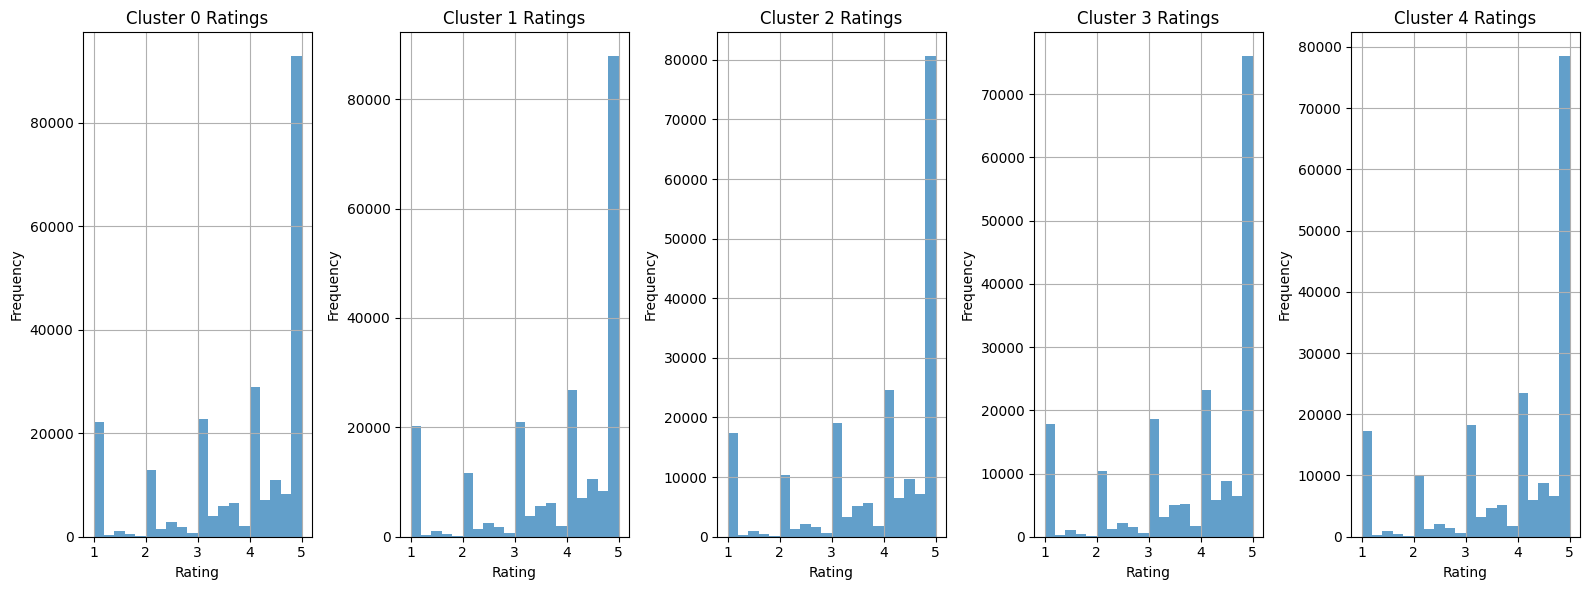

In [61]:
# 4. Rating distribution within each cluster
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    product_df[product_df['cluster'] == i]['mean_rating'].hist(bins=20, alpha=0.7)
    plt.title(f'Cluster {i} Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Review distribution within each cluser

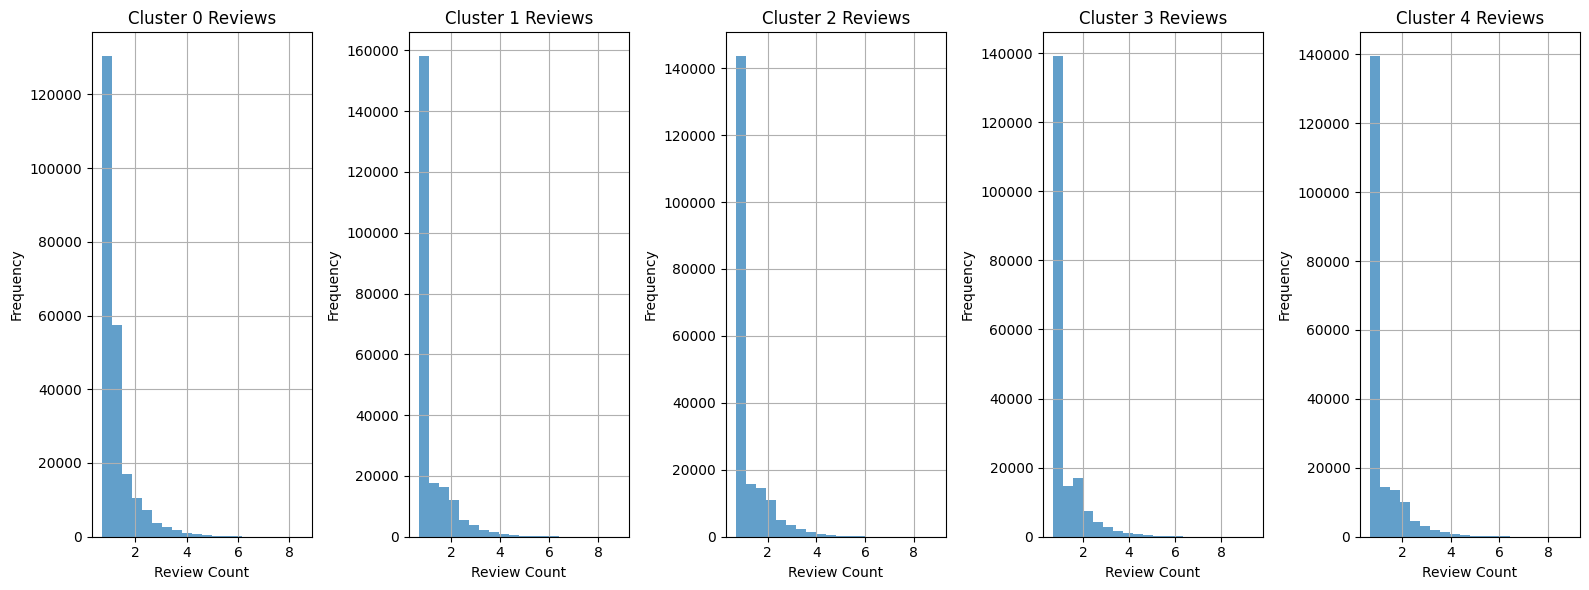

In [ ]:
# Review count distribution within each cluster
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    product_df[product_df['cluster'] == i]['total_reviews'].apply(np.log1p).hist(bins=20, alpha=0.7)
    plt.title(f'Cluster {i} Reviews')
    plt.xlabel('Review Count')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()